<a href="https://colab.research.google.com/github/Khalil1232/Causes-of-freight-train-delays./blob/main/Analysis_of_the_causes_of_freight_train_delays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyse des causes des retards des trains marchandises

# -----------------------------------------------------------

## Importing the libraries

In [1]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn import svm
from sklearn.tree import plot_tree, export_text
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
from sklearn import metrics
import mlflow
from mlflow.tracking import MlflowClient
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,recall_score,log_loss
import seaborn as sns
warnings.filterwarnings('ignore')

## Importing the dataset

In [2]:
df=pd.read_excel("BD RABAT.xlsx")
df.head()

,Date,Train,Motif,Nature_train,Ligne,Type_machine,Machine,Axe,G.Départ,G.Arrivée,...,H.Arr,R.dép,R.Arr,Unnamed: 21,Var reg,Parcours,Suppression,Composition réelle,Composition prévue ( ORDRE DE FORMATION),Observations
0,2021-01-13,1200,NaN,Fret,Casa Fes,Diesel,Autre,Fret Casa,KENITRA,SALE TABRIQUET,...,21H50,0.0,0.0,0,1,40.0,NaN,HLP,HLP MACHINE DE RESEREVE,NaN
1,2021-04-19,1200,NaN,Fret,Casa Fes,Diesel,Autre,Fret Casa,KENITRA MEDINA,SALE TABRIQUET,...,21H50,13.0,0.0,-13,1,32.9,NaN,13 T65 BLE VIDE,13 T65 VIDE +DM VHL CRN,NaN
2,2021-06-17,1200,NaN,Fret,Casa Fes,Diesel,Autre,Fret Casa,BASE MAINTENANCE,SALE TABRIQUET,...,01h52,0.0,0.0,0,1,40.0,NaN,HLP,DH 407,NaN
3,2021-06-24,1200,NaN,Fret,Casa Fes,Diesel,Autre,Fret Casa,KENITRA MEDINA,SALE TABRIQUET,...,21h50,0.0,3.0,3,1,32.9,NaN,HLP,DH364,NaN
4,2021-07-07,1200,NaN,Fret,Casa Fes,Diesel,Autre,Fret Casa,BASE MAINTENANCE,SALE TABRIQUET,...,21H50,50.0,45.0,-5,1,40.0,NaN,HLP,HLP DH 407,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20316 entries, 0 to 20315
Data columns (total 28 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   Date                                       20316 non-null  datetime64[ns]
 1   Train                                      20313 non-null  object        
 2   Motif                                      610 non-null    object        
 3   Nature_train                               19823 non-null  object        
 4   Ligne                                      20311 non-null  object        
 5   Type_machine                               19781 non-null  object        
 6   Machine                                    20313 non-null  object        
 7   Axe                                        20312 non-null  object        
 8   G.Départ                                   20309 non-null  object        
 9   G.Arrivée        

In [4]:
db= df[["Train","Motif","R.dép","R.Arr","Nature_train","Ligne","Type_machine","Machine","Chargé ou Vide ","Parcours"]]
db.head()

,Train,Motif,R.dép,R.Arr,Nature_train,Ligne,Type_machine,Machine,Chargé ou Vide,Parcours
0,1200,NaN,0.0,0.0,Fret,Casa Fes,Diesel,Autre,Vide,40.0
1,1200,NaN,13.0,0.0,Fret,Casa Fes,Diesel,Autre,Vide,32.9
2,1200,NaN,0.0,0.0,Fret,Casa Fes,Diesel,Autre,HLP,40.0
3,1200,NaN,0.0,3.0,Fret,Casa Fes,Diesel,Autre,HLP,32.9
4,1200,NaN,50.0,45.0,Fret,Casa Fes,Diesel,Autre,HLP,40.0


In [5]:
def Type_retard(x):
    if x <= 30:
        return("A")
    if 30<x <= 120:
        return("B")
    if x > 120:
        return("C")

In [6]:
db['Classe_Rdep'] = db['R.dép'].apply(Type_retard)
db['Classe_Rar'] = db['R.Arr'].apply(Type_retard)
db.head()

,Train,Motif,R.dép,R.Arr,Nature_train,Ligne,Type_machine,Machine,Chargé ou Vide,Parcours,Classe_Rdep,Classe_Rar
0,1200,NaN,0.0,0.0,Fret,Casa Fes,Diesel,Autre,Vide,40.0,A,A
1,1200,NaN,13.0,0.0,Fret,Casa Fes,Diesel,Autre,Vide,32.9,A,A
2,1200,NaN,0.0,0.0,Fret,Casa Fes,Diesel,Autre,HLP,40.0,A,A
3,1200,NaN,0.0,3.0,Fret,Casa Fes,Diesel,Autre,HLP,32.9,A,A
4,1200,NaN,50.0,45.0,Fret,Casa Fes,Diesel,Autre,HLP,40.0,B,B


## Viewing the data statistics

In [7]:
db1= db[~db['Motif'].isnull()]
dataf= db1[db1.Parcours!= 0]
dataf.head()

,Train,Motif,R.dép,R.Arr,Nature_train,Ligne,Type_machine,Machine,Chargé ou Vide,Parcours,Classe_Rdep,Classe_Rar
36,1207,PM,111.0,114.0,Fret,Casa Fes,Electrique,Autre,Chargé,209.4,B,B
50,1211,PFL,19.0,14.0,Fret,Casa Fes,Electrique,Autre,Chargé,209.4,A,A
53,1211,PM,0.0,0.0,Fret,Casa Fes,Electrique,Autre,Chargé,209.4,A,A
57,1213,PM,191.0,51.0,Fret,Casa Fes,Electrique,Autre,Chargé,209.4,C,B
59,1213,PM+PFL,11.0,8.0,Fret,Casa Fes,Electrique,VHL,Chargé,209.4,A,A


In [8]:
dataf.describe()

,R.dép,R.Arr,Parcours
count,552.000000,549.000000,555.000000
mean,85.862319,80.754098,129.880739
std,68.200297,71.308339,88.307081
min,0.000000,0.000000,12.000000
25%,27.750000,14.000000,44.290000
50%,72.500000,69.000000,110.900000
75%,120.250000,121.000000,209.400000
max,363.000000,363.000000,535.000000


In [9]:
dataf.describe(include='object')

,Train,Motif,Nature_train,Ligne,Type_machine,Machine,Chargé ou Vide,Classe_Rdep,Classe_Rar
count,555,555,555,555,555,555,555,552,549
unique,122,6,2,9,2,5,4,3,3
top,1232,PFL,Fret,Casa Fes,Electrique,Autre,Chargé,B,B
freq,61,118,344,196,435,406,279,257,236


In [10]:
dataf.to_excel("DATA.xlsx")
dataf.head()

,Train,Motif,R.dép,R.Arr,Nature_train,Ligne,Type_machine,Machine,Chargé ou Vide,Parcours,Classe_Rdep,Classe_Rar
36,1207,PM,111.0,114.0,Fret,Casa Fes,Electrique,Autre,Chargé,209.4,B,B
50,1211,PFL,19.0,14.0,Fret,Casa Fes,Electrique,Autre,Chargé,209.4,A,A
53,1211,PM,0.0,0.0,Fret,Casa Fes,Electrique,Autre,Chargé,209.4,A,A
57,1213,PM,191.0,51.0,Fret,Casa Fes,Electrique,Autre,Chargé,209.4,C,B
59,1213,PM+PFL,11.0,8.0,Fret,Casa Fes,Electrique,VHL,Chargé,209.4,A,A


## Data Visualization

In [12]:
!pip install gitly

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.3 MB/s eta 0:00:00
  Created wheel for gitly: filename=gitly-1.1.4-py3-none-any.whl size=4505 sha256=2fa64fe64ecf682d8f2e776fa08ee256811426fd3f105593cd26e9fc603e1edf
  Stored in directory: /root/.cache/pip/wheels/ac/6f/10/804eecc1778739e42d96317afd1248452cd6f1fe4c7eb56cde
Successfully built gitly


In [13]:
from gitly.colab.plot import GitlyPlotter

gitly = GitlyPlotter('github')

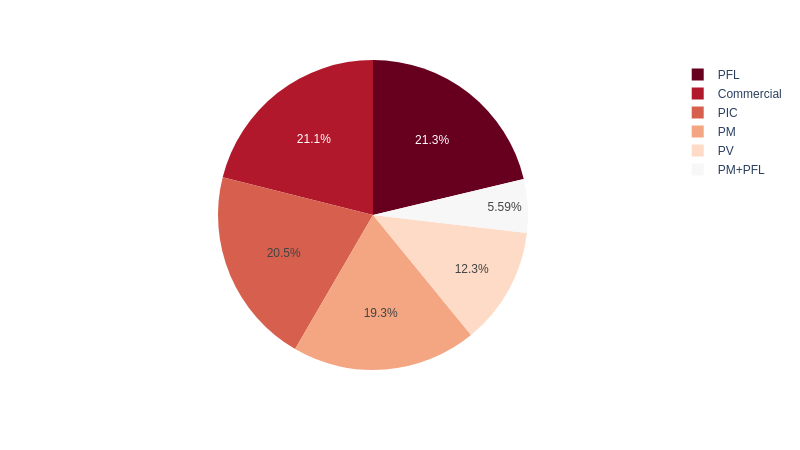

In [14]:
fig = px.pie(dataf, names='Motif', color_discrete_sequence=px.colors.sequential.RdBu)
gitly.show( fig )

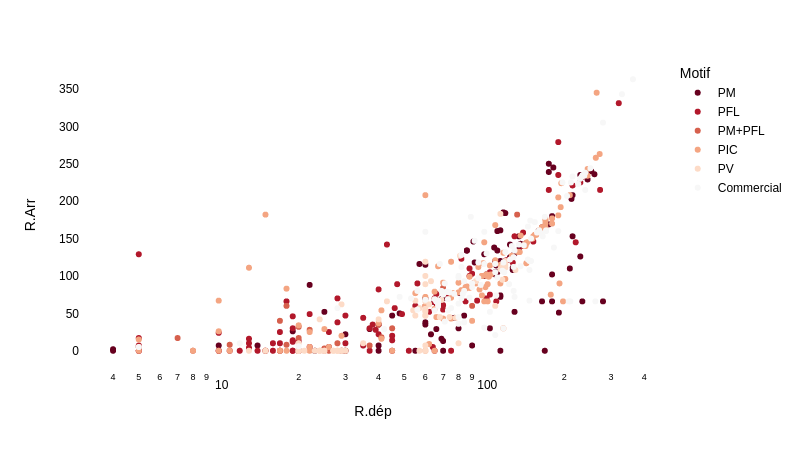

In [15]:
colors = {'background': ' #ffffff','text': '#000000'}
fig = px.scatter(dataf, x="R.dép", y="R.Arr",color="Motif",log_x=True, size_max=60,
                 color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_layout(plot_bgcolor=colors['background'],paper_bgcolor=colors['background'],font_color=colors['text'])
gitly.show( fig )

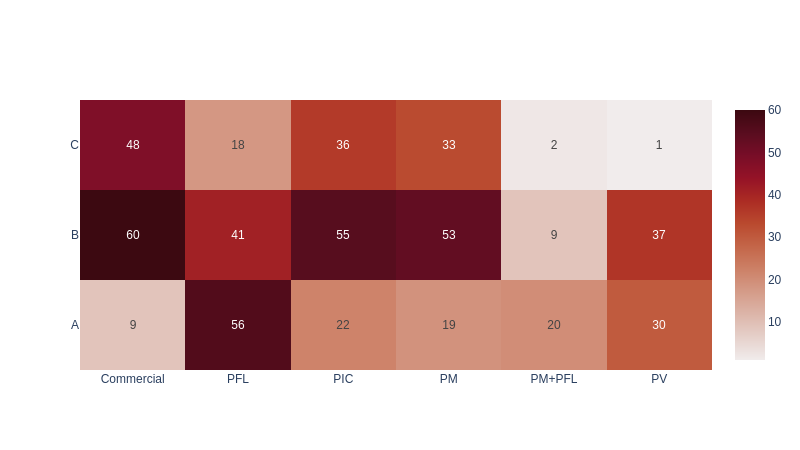

In [16]:
table = pd.pivot_table(dataf,index=["Classe_Rdep"],columns=["Motif"],values="Classe_Rar",aggfunc='count')
d=table.to_numpy()
fig = go.Figure(data=go.Heatmap(
                   z=table.to_numpy(),
                   x=['Commercial', 'PFL', 'PIC', 'PM','PM+PFL', 'PV'],
                    y=["A","B","C"],
                  text=table.to_numpy(),
                  texttemplate="%{text}",colorscale='amp'
                   ))

gitly.show( fig )

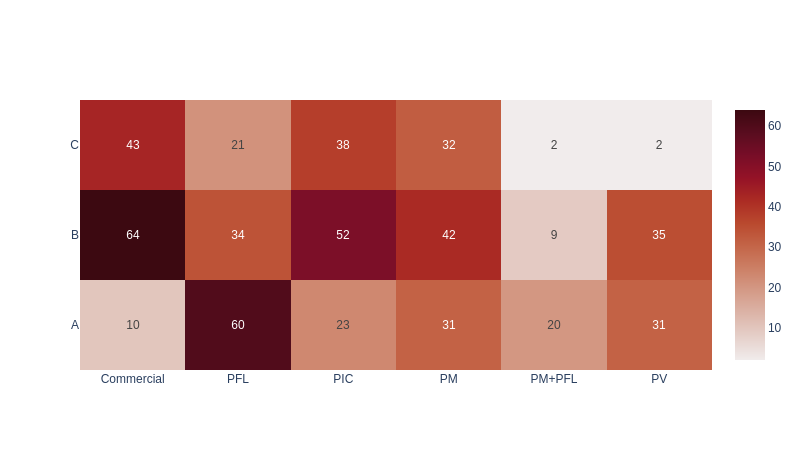

In [17]:
table1 = pd.pivot_table(dataf,index=["Classe_Rar"],columns=["Motif"],values="Classe_Rdep", aggfunc='count')
d=table1.to_numpy()
fig = go.Figure(data=go.Heatmap(
                   z=table1.to_numpy(),
                   x=['Commercial', 'PFL', 'PIC', 'PM','PM+PFL', 'PV'],
                    y=['A','B','C'],
                  text=table1.to_numpy(),
                  texttemplate="%{text}",colorscale='amp'
                   ))
gitly.show( fig )

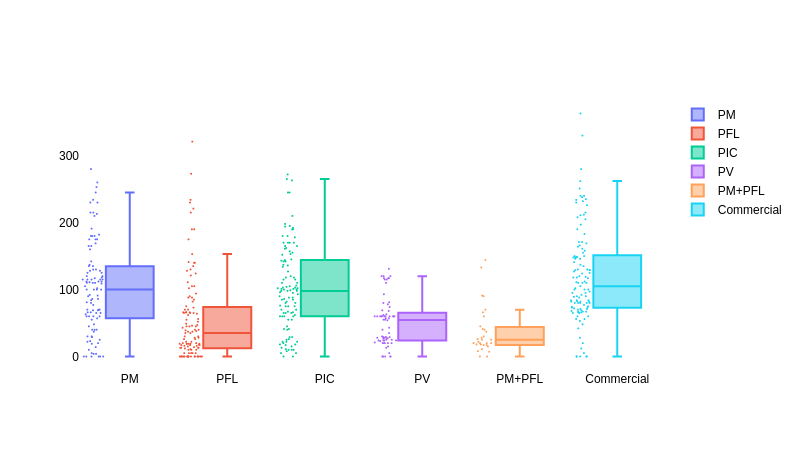

In [18]:
x_data = ['PM', 'PFL','PIC', 'PV','PM+PFL','Commercial']
d1=dataf[dataf["Motif"]=="PM"]
d2=dataf[dataf["Motif"]=="PFL"]
d3=dataf[dataf["Motif"]=="PIC"]
d4=dataf[dataf["Motif"]=="PV"]
d5=dataf[dataf["Motif"]=="PM+PFL"]
d6=dataf[dataf["Motif"]=="Commercial"]
y1=d1["R.dép"].values
y2=d2["R.dép"].values
y3=d3["R.dép"].values
y4=d4["R.dép"].values
y5=d5["R.dép"].values
y6=d6["R.dép"].values
y_data = [y1, y2, y3, y4, y5,y6]
fig = go.Figure()
for xd, yd in zip(x_data, y_data):
        fig.add_trace(go.Box(
            y=yd,
            name=xd,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            marker_size=2,))
fig.update_layout(plot_bgcolor='#ffffff',
                   paper_bgcolor='#ffffff',
                   font_color='#000000')

gitly.show( fig )

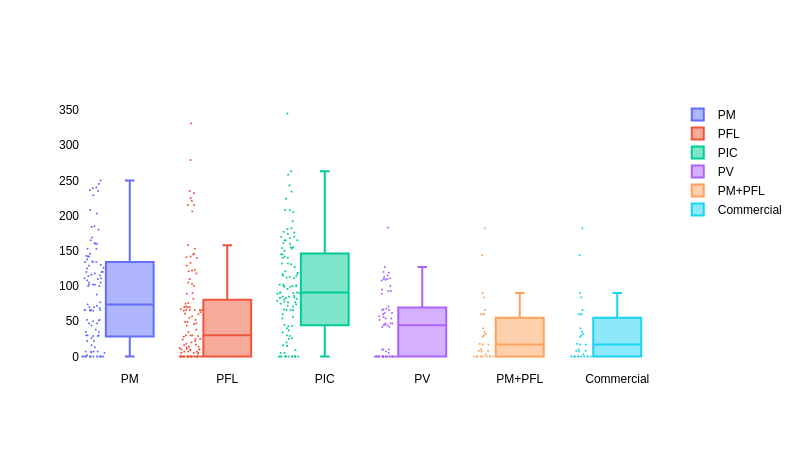

In [20]:
y11=d1["R.Arr"].values
y22=d2["R.Arr"].values
y33=d3["R.Arr"].values
y44=d4["R.Arr"].values
y55=d5["R.Arr"].values
y66=d5["R.Arr"].values
y_data1 = [y11, y22, y33, y44, y55,y66]
fig = go.Figure()
for xd, yd in zip(x_data, y_data1):
        fig.add_trace(go.Box(
            y=yd,
            name=xd,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            marker_size=2,))
fig.update_layout(plot_bgcolor='#ffffff',
                   paper_bgcolor='#ffffff',
                   font_color='#000000')

gitly.show( fig )

In [21]:
dataf.isnull().sum()

Train              0
Motif              0
R.dép              3
R.Arr              6
Nature_train       0
Ligne              0
Type_machine       0
Machine            0
Chargé ou Vide     0
Parcours           0
Classe_Rdep        3
Classe_Rar         6
dtype: int64

In [22]:
dataf["R.dép"].median()

72.5

In [23]:
dataf["R.Arr"].median()

69.0

In [24]:
dataf["R.dép"].mean()

85.8623188405797

In [25]:
dataf["R.Arr"].mean()

80.75409836065573

In [26]:
dataf["R.dép"]=dataf["R.dép"].fillna(dataf["R.dép"].mean())
dataf["R.Arr"]=dataf["R.Arr"].fillna(dataf["R.Arr"].mean())

In [27]:
data=dataf.drop(['Classe_Rdep', 'Classe_Rar'], axis=1)
data['Classe_Rdep'] = data['R.dép'].apply(Type_retard)
data['Classe_Rar'] = data['R.Arr'].apply(Type_retard)
data.head()

,Train,Motif,R.dép,R.Arr,Nature_train,Ligne,Type_machine,Machine,Chargé ou Vide,Parcours,Classe_Rdep,Classe_Rar
36,1207,PM,111.0,114.0,Fret,Casa Fes,Electrique,Autre,Chargé,209.4,B,B
50,1211,PFL,19.0,14.0,Fret,Casa Fes,Electrique,Autre,Chargé,209.4,A,A
53,1211,PM,0.0,0.0,Fret,Casa Fes,Electrique,Autre,Chargé,209.4,A,A
57,1213,PM,191.0,51.0,Fret,Casa Fes,Electrique,Autre,Chargé,209.4,C,B
59,1213,PM+PFL,11.0,8.0,Fret,Casa Fes,Electrique,VHL,Chargé,209.4,A,A


In [28]:
data.isnull().sum()

Train              0
Motif              0
R.dép              0
R.Arr              0
Nature_train       0
Ligne              0
Type_machine       0
Machine            0
Chargé ou Vide     0
Parcours           0
Classe_Rdep        0
Classe_Rar         0
dtype: int64

In [29]:
data["Motif"].value_counts()

PFL           118
Commercial    117
PIC           114
PM            107
PV             68
PM+PFL         31
Name: Motif, dtype: int64

In [30]:
data["Classe_Rdep"].value_counts()

B    260
A    157
C    138
Name: Classe_Rdep, dtype: int64

In [31]:
data["Classe_Rar"].value_counts()

B    242
A    175
C    138
Name: Classe_Rar, dtype: int64

In [32]:
data["Nature_train"].value_counts()

Fret         344
Phosphate    211
Name: Nature_train, dtype: int64

In [33]:
data["Ligne"].value_counts()

Casa Fes                  196
Casa Khouribga             97
Benguerir Safi             83
Casa Marrakech             61
Tanger Port Tanger Med     48
Fes Oujda                  32
Casa Jorf                  30
Taourirt Nador              7
Sidikacem Tanger            1
Name: Ligne, dtype: int64

In [34]:
data["Type_machine"].value_counts()

Electrique    435
Diesel        120
Name: Type_machine, dtype: int64

In [35]:
data["Machine"].value_counts()

Autre       406
VHL          82
DT           48
UM           15
DT + VHL      4
Name: Machine, dtype: int64

In [36]:
data["Chargé ou Vide "].value_counts()

Chargé    279
Vide      264
HLP        11
HLP         1
Name: Chargé ou Vide , dtype: int64

In [37]:
data["Classe_Rdep"]=data["Classe_Rdep"].map({'A': 1, 'B': 2,'C':3})
data["Classe_Rar"]=data["Classe_Rar"].map({'A': 1, 'B': 2,'C':3})

In [38]:
data.head()

,Train,Motif,R.dép,R.Arr,Nature_train,Ligne,Type_machine,Machine,Chargé ou Vide,Parcours,Classe_Rdep,Classe_Rar
36,1207,PM,111.0,114.0,Fret,Casa Fes,Electrique,Autre,Chargé,209.4,2,2
50,1211,PFL,19.0,14.0,Fret,Casa Fes,Electrique,Autre,Chargé,209.4,1,1
53,1211,PM,0.0,0.0,Fret,Casa Fes,Electrique,Autre,Chargé,209.4,1,1
57,1213,PM,191.0,51.0,Fret,Casa Fes,Electrique,Autre,Chargé,209.4,3,2
59,1213,PM+PFL,11.0,8.0,Fret,Casa Fes,Electrique,VHL,Chargé,209.4,1,1


In [39]:
data["Nature_train"]=data["Nature_train"].map({'Fret': 1, 'Phosphate': 2})
data["Chargé ou Vide "]=data["Chargé ou Vide "].map({'Chargé': 1, 'Vide': 2,'HLP':3})

In [40]:
data.head()

,Train,Motif,R.dép,R.Arr,Nature_train,Ligne,Type_machine,Machine,Chargé ou Vide,Parcours,Classe_Rdep,Classe_Rar
36,1207,PM,111.0,114.0,1,Casa Fes,Electrique,Autre,1.0,209.4,2,2
50,1211,PFL,19.0,14.0,1,Casa Fes,Electrique,Autre,1.0,209.4,1,1
53,1211,PM,0.0,0.0,1,Casa Fes,Electrique,Autre,1.0,209.4,1,1
57,1213,PM,191.0,51.0,1,Casa Fes,Electrique,Autre,1.0,209.4,3,2
59,1213,PM+PFL,11.0,8.0,1,Casa Fes,Electrique,VHL,1.0,209.4,1,1


In [41]:
data["Type_machine"]=data["Type_machine"].map({'Electrique': 1, 'Diesel': 2})
data["Ligne"]=data["Ligne"].map(
{  'Casa Fes': 1,
    'Casa Khouribga': 2,
    'Benguerir Safi': 3,
    'Casa Marrakech': 4,
    'Tanger Port Tanger Med': 5,
    'Fes Oujda': 6,
    'Casa Jorf': 7,
    'Taourirt Nador': 8,
    'Sidikacem Tanger': 9,
    }
)

In [42]:
data["Motif"]=data["Motif"].map(
{  'PFL': 1,
    'PIC': 2,
    'Commercial': 3,
    'PM': 4,
    'PV': 5,
    'PM+PFL': 6
    }
)

In [43]:
data["Machine"]=data["Machine"].map(
{  'DT': 1,
    'UM': 2,
    'VHL': 3,
    'DT + VHL': 4,
    'Autre': 5,
    }
)

In [44]:
data.head()

,Train,Motif,R.dép,R.Arr,Nature_train,Ligne,Type_machine,Machine,Chargé ou Vide,Parcours,Classe_Rdep,Classe_Rar
36,1207,4,111.0,114.0,1,1,1,5,1.0,209.4,2,2
50,1211,1,19.0,14.0,1,1,1,5,1.0,209.4,1,1
53,1211,4,0.0,0.0,1,1,1,5,1.0,209.4,1,1
57,1213,4,191.0,51.0,1,1,1,5,1.0,209.4,3,2
59,1213,6,11.0,8.0,1,1,1,3,1.0,209.4,1,1


In [45]:
df_final = data.drop(['Train','R.dép','R.Arr','Parcours'],axis='columns')
df_final= df_final[~df_final['Chargé ou Vide '].isnull()]
df_final.head()

,Motif,Nature_train,Ligne,Type_machine,Machine,Chargé ou Vide,Classe_Rdep,Classe_Rar
36,4,1,1,1,5,1.0,2,2
50,1,1,1,1,5,1.0,1,1
53,4,1,1,1,5,1.0,1,1
57,4,1,1,1,5,1.0,3,2
59,6,1,1,1,3,1.0,1,1


In [46]:
X = df_final.drop(['Motif'],axis='columns')
y=df_final["Motif"]

In [47]:
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.15,random_state=42)

In [ ]:
!mlflow ui

[2022-12-18 21:37:41 +0000] [269] [INFO] Starting gunicorn 20.1.0
[2022-12-18 21:37:41 +0000] [269] [INFO] Listening at: http://127.0.0.1:5000 (269)
[2022-12-18 21:37:41 +0000] [269] [INFO] Using worker: sync
[2022-12-18 21:37:41 +0000] [271] [INFO] Booting worker with pid: 271
[2022-12-18 21:37:41 +0000] [272] [INFO] Booting worker with pid: 272
[2022-12-18 21:37:41 +0000] [273] [INFO] Booting worker with pid: 273
[2022-12-18 21:37:41 +0000] [274] [INFO] Booting worker with pid: 274
[2022-12-18 23:04:12 +0000] [269] [INFO] Handling signal: int
[2022-12-18 23:04:13 +0000] [271] [INFO] Worker exiting (pid: 271)
[2022-12-18 23:04:13 +0000] [272] [INFO] Worker exiting (pid: 272)
[2022-12-18 23:04:13 +0000] [273] [INFO] Worker exiting (pid: 273)
[2022-12-18 23:04:13 +0000] [274] [INFO] Worker exiting (pid: 274)

Aborted!
[2022-12-18 23:04:13 +0000] [269] [INFO] Shutting down: Master


In [ ]:
experiment_name = "Classifiers"
artifact_repository = './mlflow-run'

mlflow.set_tracking_uri('http://127.0.0.1:5000/')

client = MlflowClient()


try:
    experiment_id = client.create_experiment(experiment_name, artifact_location=artifact_repository)
except:
    experiment_id = client.get_experiment_by_name(experiment_name).experiment_id

In [ ]:
def model_experimentation(classifier, param,model_name, run_name):
    with mlflow.start_run(experiment_id=experiment_id, run_name=run_name) as run:
        run_id = run.info.run_uuid

        MlflowClient().set_tag(run_id,
                               "mlflow.note.content",
                               "Analyse des causes des retards des trains marchandises")


        mlflow.sklearn.autolog()

        tags = {"Application": "Analyse des causes des retards des trains marchandises"}

        mlflow.set_tags(tags)



        clf = classifier(**param)
        clf.fit(X_train, y_train)
        mlflow.log_params(param)
        y_pred = clf.predict(X_test)
#         y_pred_prob = clf.predict_proba(X_test)
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred,average='micro')
        recall = recall_score(y_test, y_pred,average='macro')
#         entropy = log_loss(y_test, y_pred_prob)
        print({'accuracy': round(acc, 2), 'precision': round(prec, 2), 'recall': round(recall, 2),
#                 'entropy': round(entropy, 2)
              })


        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("precision", prec)
        mlflow.log_metric("recall", recall)
#         mlflow.log_metric("entropy", entropy)


        y_pred = clf.predict(X_test)
        data = confusion_matrix(y_test, y_pred)
        df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
        df_cm.index.name = 'Actual'
        df_cm.columns.name = 'Predicted'

        f, ax = plt.subplots(figsize=(8, 8))
        cmap = sns.cubehelix_palette(light=1, as_cmap=True)

        sns.heatmap(df_cm, cbar=False, annot=True, cmap=cmap, square=True, fmt='.0f',
                    annot_kws={'size': 10})
        plt.title('Actuals vs Predicted')
        filename = f'./images/{model_name}_confusion_matrix.png'
        plt.savefig(filename)
        mlflow.log_artifact(filename)
        mlflow.sklearn.log_model(clf, "Classifier")

In [ ]:
classifier = RandomForestClassifier
param = {}
model_name='RandomForest_Classifier'
run_name = 'RandomForest_Classifier'
model_experimentation(classifier, param,model_name, run_name)

In [ ]:
classifier = DecisionTreeClassifier
param = {}
model_name='DecisionTree_Classifier'
run_name = 'DecisionTree_Classifier'
model_experimentation(classifier, param,model_name, run_name)

{'accuracy': 0.44, 'precision': 0.44, 'recall': 0.38}


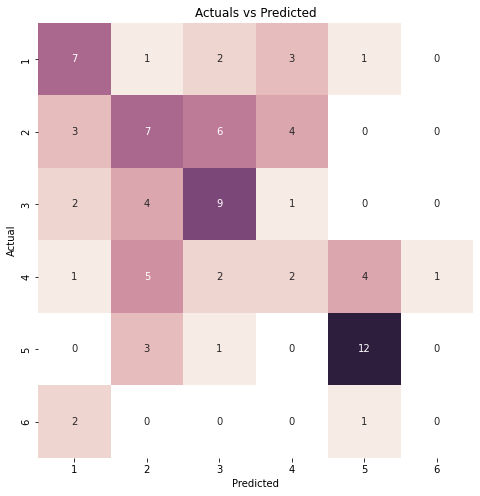

In [ ]:
classifier = KNeighborsClassifier
param = {}
model_name='KNeighbors_Classifier'
run_name = 'KNeighbors_Classifier'
model_experimentation(classifier, param,model_name, run_name)

{'accuracy': 0.42, 'precision': 0.42, 'recall': 0.35}


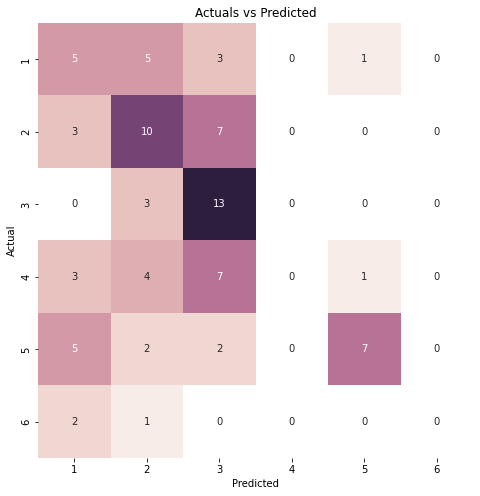

In [ ]:
classifier = SGDClassifier
param = {}
model_name='SGD_Classifier'
run_name = 'SGD_Classifier'
model_experimentation(classifier, param,model_name, run_name)

{'accuracy': 0.46, 'precision': 0.46, 'recall': 0.4}


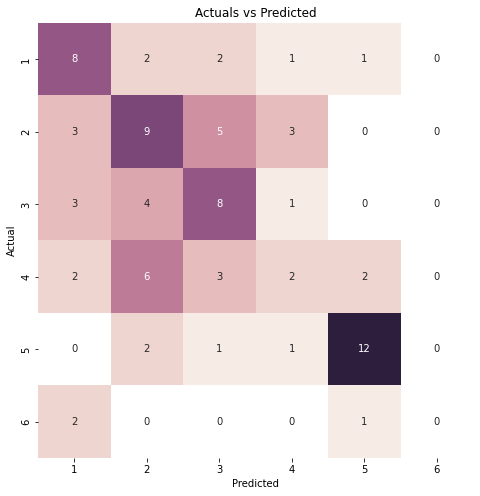

In [ ]:
from sklearn.svm import SVC
classifier =SVC
param = {}
model_name='SVC_Classifier'
run_name = 'SVC_Classifier'
model_experimentation(classifier, param,model_name, run_name)

In [ ]:
# def find_best_model_using_gridsearchcv(X,y):

#     algos = {
#         'DecisionTree_Classifier' : {
#             'model': DecisionTreeClassifier(),
#             'params': {
#                 'criterion' : ["gini", "entropy"],
#                 'max_depth' : [3,4,5,6],
#                 'max_features': [2,3,4,5],
#                 'min_samples_leaf':[5,6,7,10],
#                 'min_samples_split': [12,13,14,15]}
#         },


#         'RandomForest_Classifier': {
#             'model': RandomForestClassifier(),
#             'params': {
#                 'criterion' : ["gini", "entropy"],
#                 'max_depth' : [3,4,5,6],
#                 'max_features': [2,3,4,5],
#                 'min_samples_leaf':[5,6,7,10],
#                 'min_samples_split': [12,13,14,15]}
#         },

#         'KNeighbors_Classifier()' : {
#             'model': KNeighborsClassifier(),
#             'params': {
#                 'leaf_size' : [2,3,4,10],
#                 'n_neighbors' : [6,7,8,9,10,12],
#                 'p': [1,2]}
#         },


#         'SVM_Classifier': {
#             'model': svm.SVC(),
#             'params': {
#                 'C': [0.1, 1, 10, 100, 1000],
#                 'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
#                 'kernel': ['rbf','sigmoid','linear']}
#         },
#          'SGD_Classifier' : {
#             'model': SGDClassifier(),
#             'params': {
#                 "loss" : ["hinge", "log", "squared_hinge", "modified_huber"],
#                 "alpha" : [0.0001, 0.001, 0.01, 0.1],
#                 "penalty" : ["l2", "l1", "none"],}
#         },

#     }
#     scores = []
#     cv = ShuffleSplit(n_splits=2, test_size=0.15, random_state=42)
#     for algo_name, config in algos.items():
#         gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
#         gs.fit(X,y)
#         scores.append({
#             'model': algo_name,
#             'best_score': gs.best_score_,
#             'best_params': gs.best_params_
#         })

#     return pd.DataFrame(scores,columns=['model','best_score','best_params'])

In [ ]:
# models=find_best_model_using_gridsearchcv(X_train, y_train)

In [ ]:
# models

In [ ]:
classifier1 = DecisionTreeClassifier()
classifier1.fit(X_train, y_train)
classifier1.score(X_test,y_test)

2022/09/07 12:50:27 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3f6ced43d90f403c9e95bf332585e07a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


0.4523809523809524

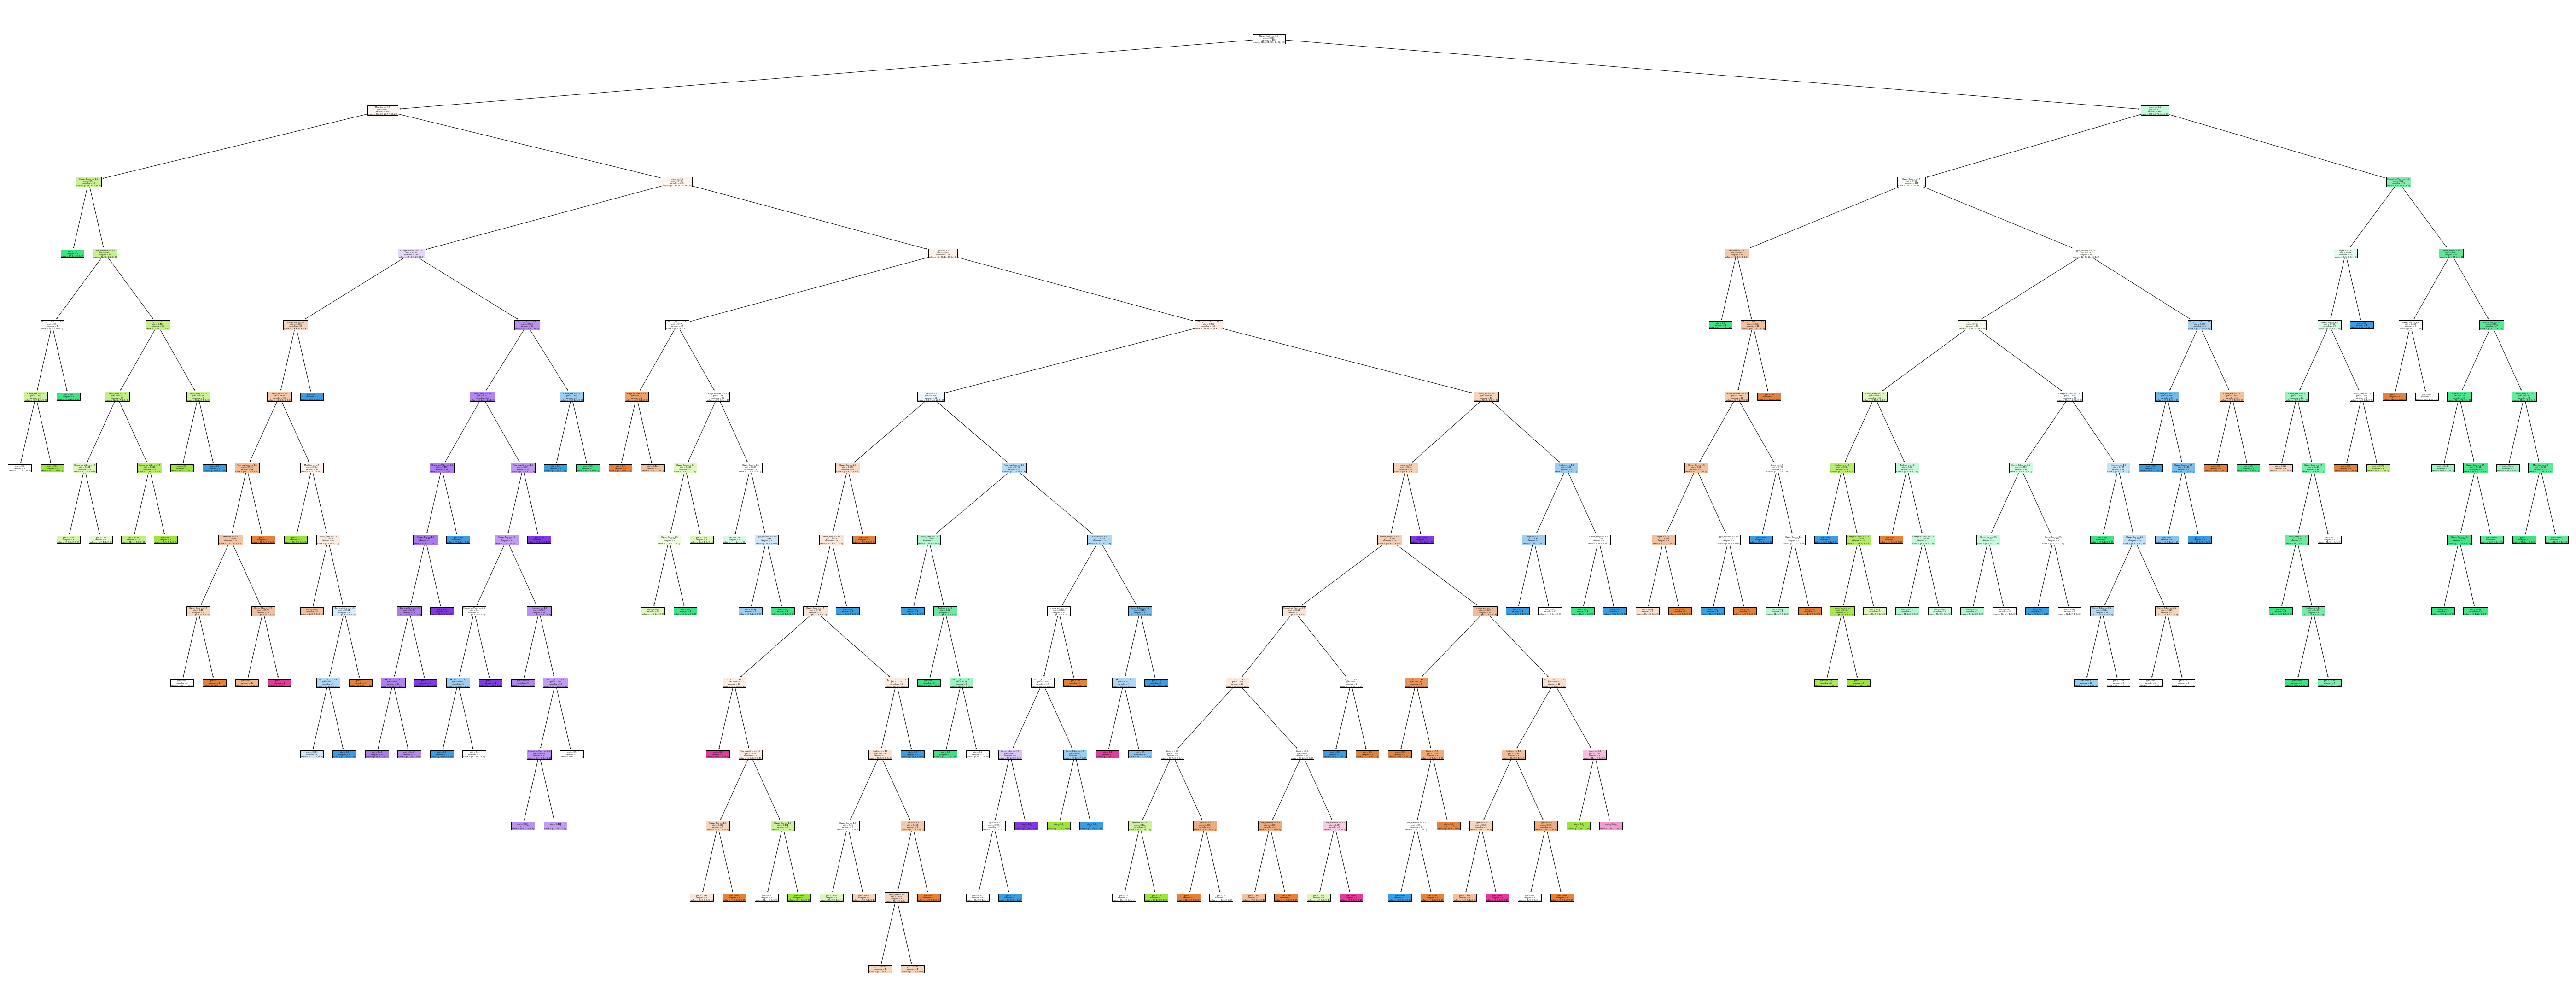

In [ ]:
plt.figure(figsize =(100,40))
plot_tree(classifier1, feature_names=X_train.columns, filled=True);

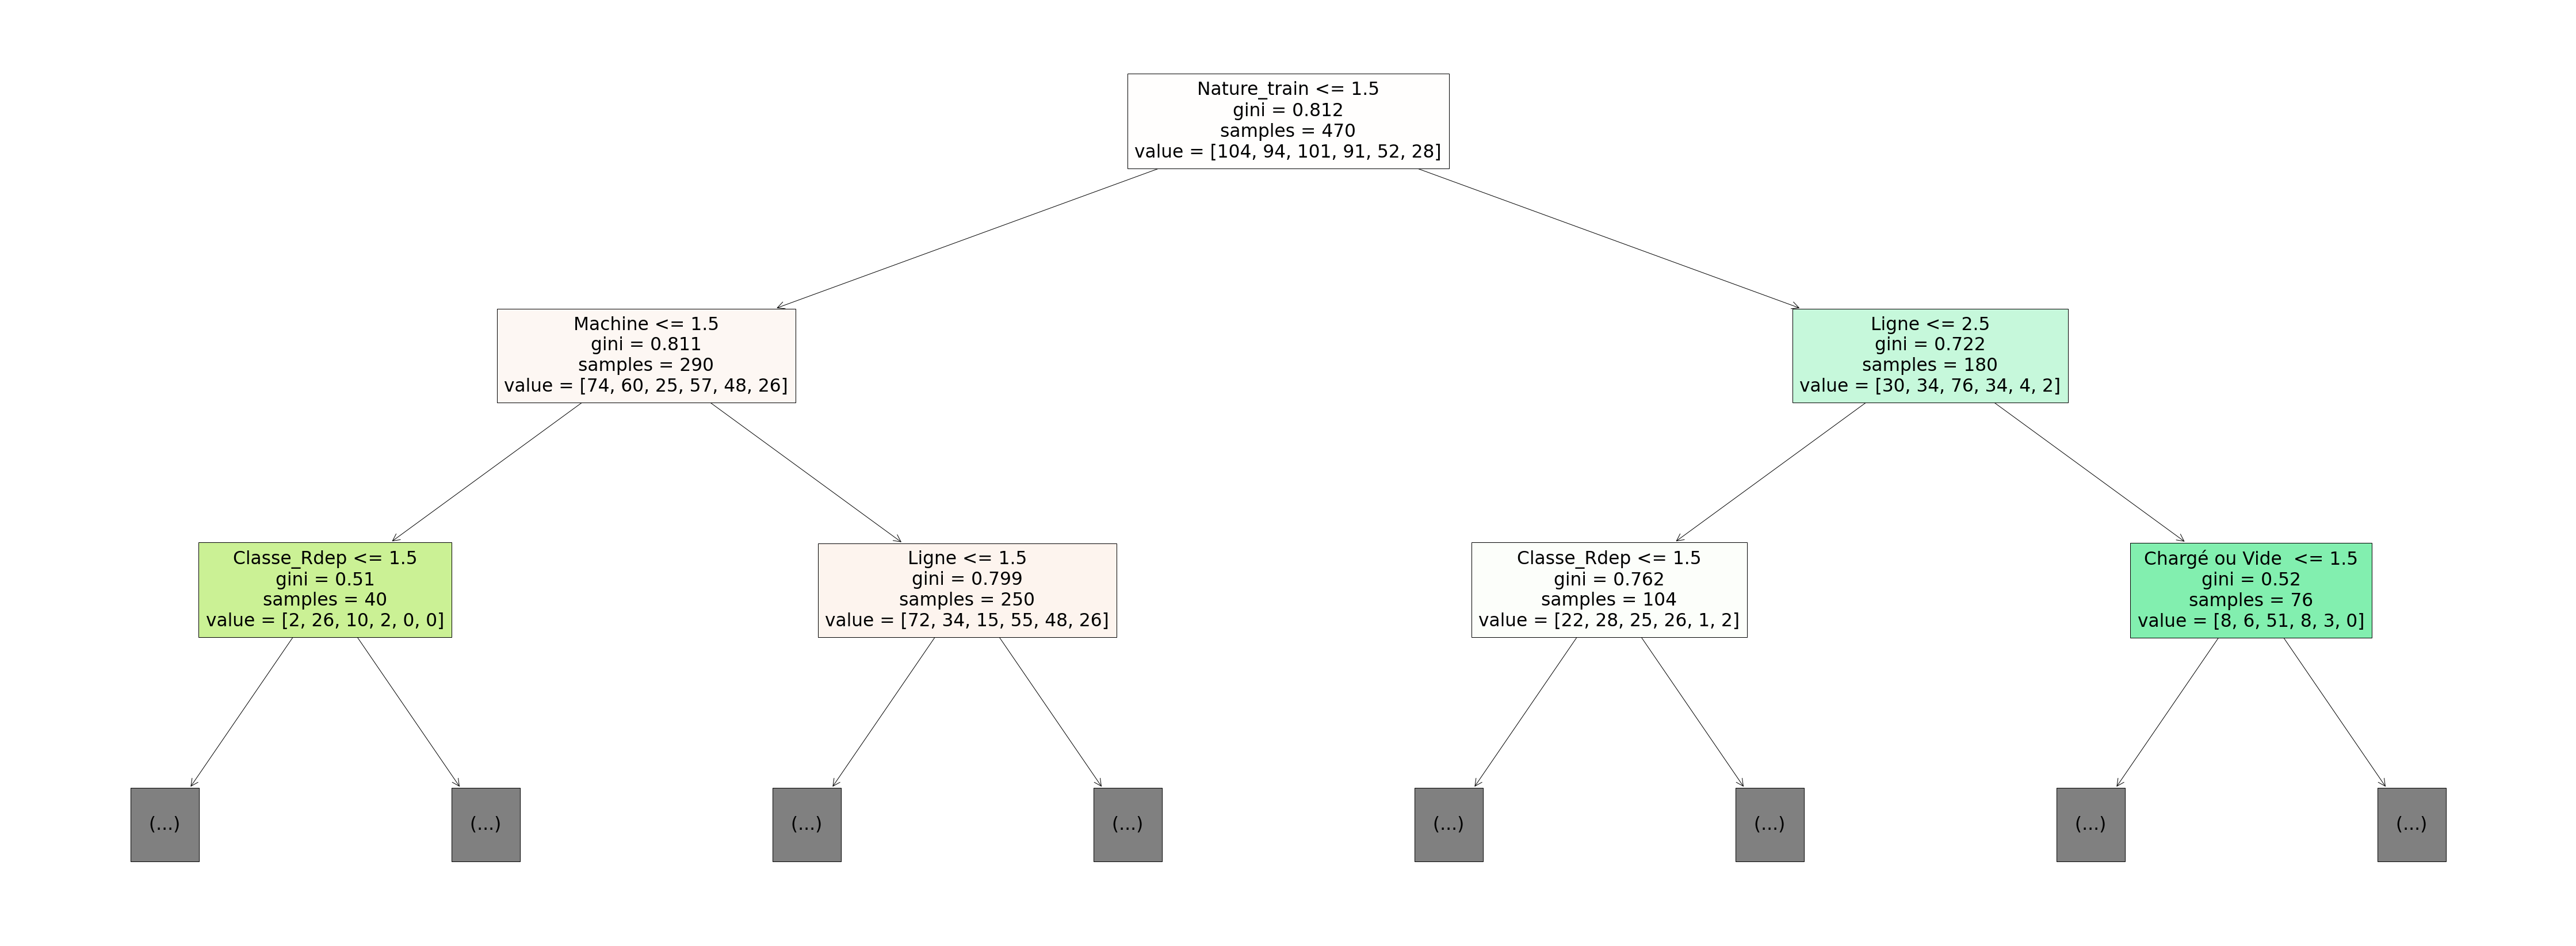

In [ ]:
plt.figure(figsize =(80,30))
plot_tree(classifier1, feature_names=X_train.columns, max_depth=2, filled=True);

In [ ]:
def predict(Nature_train,Ligne,Type_machine,Machine,Chargé_Vide,Classe_Rdep,Classe_Rar):
    l=[[0]*(len(X.columns))]
    l0=['Fret', 'Phosphate']
    l1=['Casa Fes','Casa Khouribga','Benguerir Safi','Casa Marrakech',
    'Tanger Port Tanger Med','Fes Oujda','Casa Jorf','Taourirt Nador','Sidikacem Tanger']
    l2=['Electrique', 'Diesel']
    l3=['DT','UM','VHL','DT + VHL','Autre']
    l4=['Chargé', 'Vide','HLP']
    l5=["A","B","C"]
    l6=["A","B","C"]
    ly=['PFL','PIC','Commercial','PM','PV','PM+PFL']
    if Nature_train in l0:
        l[0][0]=l0.index(Nature_train)+1
    if Ligne in l1:
        l[0][1]=l1.index(Ligne)+1
    if Type_machine in l2:
        l[0][2]=l2.index(Type_machine)+1
    if Machine in l3:
        l[0][3]=l3.index(Machine)+1
    if Chargé_Vide in l4:
        l[0][4]=l4.index(Chargé_Vide)+1
    if Classe_Rdep in l5:
        l[0][5]=l5.index(Classe_Rdep)+1
    if Classe_Rar in l6:
        l[0][6]=l6.index(Classe_Rar)+1
    a=classifier1.predict(l)
    b=a[0]-1
    print("Motif de retard est :",ly[b])

In [ ]:
predict("Fret","Casa Fes","Electrique","DT","Chargé","A","B")

Motif de retard est : Commercial


In [ ]:
predict("Fret","Casa Marrakech","Electrique","DT","Chargé","B","B")

Motif de retard est : PIC


In [ ]:
predict("Fret","Casa Khouribga","Diesel","UM","Vide","C","C")

Motif de retard est : Commercial
